# Exercise 3

## Imports

In [ ]:
# !pip install -r requirements.txt

In [2]:
import time
import os
import transformers
import optuna
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss, balanced_accuracy_score
from sklearn.svm import SVC  
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

D:\TU Wien\Semester 3\ML\ml-37\Exercise 3\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


## Data loading

In [3]:
ag_news_train_df = pd.read_csv('data/ag_news_train.csv')
ag_news_test_df = pd.read_csv('data/ag_news_test.csv')
amazon_reviews_df = pd.read_csv('data/cleaned_amazon_reviews.csv')

In [4]:
ag_news_train_df.shape

(120000, 3)

In [5]:
ag_news_test_df.shape

(7600, 3)

In [6]:
ag_news_train_df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [7]:
amazon_reviews_df.shape

(17340, 4)

In [8]:
amazon_reviews_df.head()

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0


In [9]:
amazon_reviews_df.isna().sum()

sentiments               0
cleaned_review           3
cleaned_review_length    0
review_score             0
dtype: int64

<AxesSubplot: >

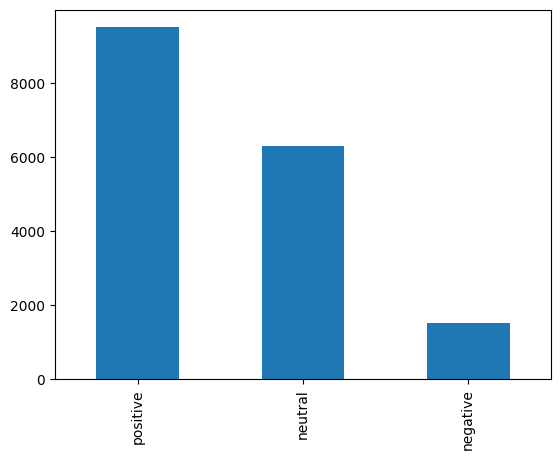

In [10]:
amazon_reviews_df.sentiments.value_counts().plot(kind='bar')

Unbalanced target

<AxesSubplot: >

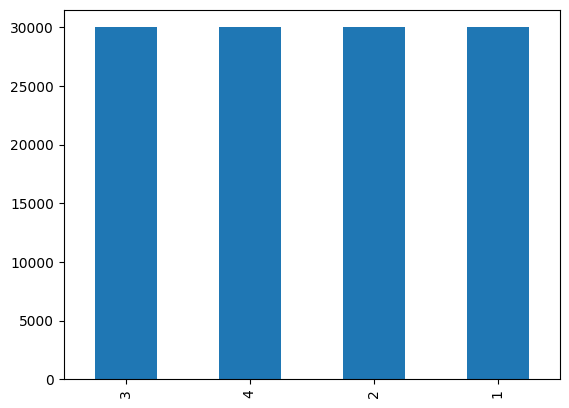

In [11]:
ag_news_train_df['Class Index'].value_counts().plot(kind='bar')

Balanced target

#### Distribution of review lengths

(array([1.4993e+04, 1.8380e+03, 3.4300e+02, 8.3000e+01, 5.0000e+01,
        1.2000e+01, 9.0000e+00, 5.0000e+00, 4.0000e+00, 3.0000e+00]),
 array([  0. ,  57.1, 114.2, 171.3, 228.4, 285.5, 342.6, 399.7, 456.8,
        513.9, 571. ]),
 <BarContainer object of 10 artists>)

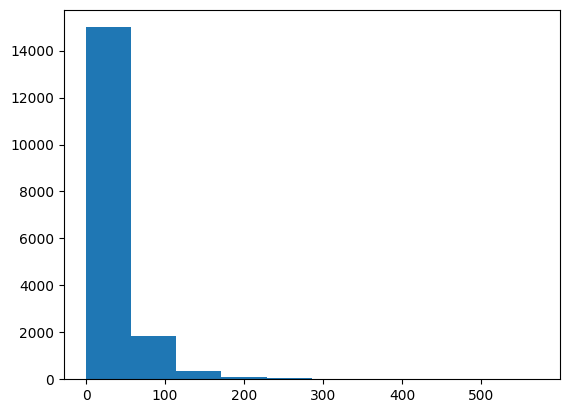

In [12]:
plt.hist(amazon_reviews_df.cleaned_review_length)

#### Distribution of the news article lengths

(array([4.8100e+03, 6.7638e+04, 4.1664e+04, 4.2770e+03, 1.0700e+03,
        2.9800e+02, 9.3000e+01, 9.0000e+01, 2.9000e+01, 3.1000e+01]),
 array([  6. , 103.9, 201.8, 299.7, 397.6, 495.5, 593.4, 691.3, 789.2,
        887.1, 985. ]),
 <BarContainer object of 10 artists>)

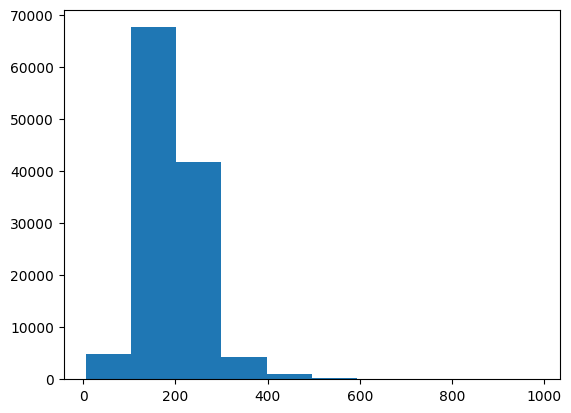

In [13]:
plt.hist(ag_news_train_df.Description.str.len())

In [14]:
ag_news_train_df.isna().any()

Class Index    False
Title          False
Description    False
dtype: bool

#### Removing NaNs

In [15]:
amazon_reviews_df.dropna(inplace=True)

### Splitting amazon reviews into train and test set

In [16]:
X_amazon_reviews = amazon_reviews_df.drop(columns=['sentiments'])
y_amazon_reviews = amazon_reviews_df['sentiments']

In [17]:
X_train_reviews, X_test_reviews, y_train_reviews, y_test_reviews = train_test_split(X_amazon_reviews,
                                                                                   y_amazon_reviews,
                                                                                   random_state=42,
                                                                                   test_size=0.2)

In [18]:
X_train_reviews, X_valid_reviews, y_train_reviews, y_valid_reviews = train_test_split(X_train_reviews,
                                                                                     y_train_reviews,
                                                                                     random_state=42,
                                                                                     test_size = 0.33)

### Splitting ag news into X and y's

Merging Title and Description into one field, "Text"

In [19]:
ag_news_train_df['Text'] = ag_news_train_df[['Title', 'Description']].agg(' '.join,axis=1)
ag_news_test_df['Text'] = ag_news_test_df[['Title', 'Description']].agg(' '.join,axis=1)

In [20]:
ag_news_train_df['Text']

0         Wall St. Bears Claw Back Into the Black (Reute...
1         Carlyle Looks Toward Commercial Aerospace (Reu...
2         Oil and Economy Cloud Stocks' Outlook (Reuters...
3         Iraq Halts Oil Exports from Main Southern Pipe...
4         Oil prices soar to all-time record, posing new...
                                ...                        
119995    Pakistan's Musharraf Says Won't Quit as Army C...
119996    Renteria signing a top-shelf deal Red Sox gene...
119997    Saban not going to Dolphins yet The Miami Dolp...
119998    Today's NFL games PITTSBURGH at NY GIANTS Time...
119999    Nets get Carter from Raptors INDIANAPOLIS -- A...
Name: Text, Length: 120000, dtype: object

In [21]:
X_train_news = ag_news_train_df['Text']
y_train_news = ag_news_train_df['Class Index']

X_test_news = ag_news_test_df['Text']
y_test_news = ag_news_test_df['Class Index']

In [22]:
X_train_news, X_valid_news, y_train_news, y_valid_news = train_test_split(X_train_news,
                                                                          y_train_news,
                                                                          random_state=42,
                                                                          test_size = 0.33)

## Naive feature extraction

### Uni-Bigram vectorizer

Because documents are quite short on average, we used the uni-bigram vectorizer (contains both unigrams and bigrams)

Following pieces of code were taken from Sklearn's text feature extraction tutorial. (https://scikit-learn.org/stable/modules/feature_extraction.html)

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
bigram_vectorizer = CountVectorizer(ngram_range=(1,2), token_pattern=r'\b\w+\b', min_df=1)

In [25]:
X_train_reviews_tr = bigram_vectorizer.fit_transform(X_train_reviews.cleaned_review)
X_valid_reviews_tr = bigram_vectorizer.transform(X_valid_reviews.cleaned_review)
X_test_reviews_tr = bigram_vectorizer.transform(X_test_reviews.cleaned_review)

In [26]:
bigram_vectorizer.get_feature_names_out()

array(['a', 'a bit', 'a bunch', ..., 'zoom while', 'zooms', 'zooms down'],
      dtype=object)

In [27]:
X_train_news_tr = bigram_vectorizer.fit_transform(X_train_news)
X_valid_news_tr = bigram_vectorizer.transform(X_valid_news)
X_test_news_tr = bigram_vectorizer.transform(X_test_news)

## Training shallow models

Balanced accuracy score is used to macro average across classes.

For hyperparam tuning only a half of training data will be used for performance reasons.

In [ ]:
np.random.seed(42)
reviews_train_idx = np.random.choice(y_train_reviews.shape[0], 
                                     replace=False, size=y_train_reviews.shape[0]//2)
news_train_idx = np.random.choice(y_train_news.shape[0], 
                                     replace=False, size=y_train_news.shape[0]//8)

In [ ]:
X_train_reviews_half = X_train_reviews_tr[reviews_train_idx,:]
y_train_reviews_half = y_train_reviews.iloc[reviews_train_idx]

X_train_news_16th = X_train_news_tr[news_train_idx,:]
y_train_news_16th = y_train_news.iloc[news_train_idx]

X_train_news_8th = X_train_news_tr[news_train_idx,:]
y_train_news_8th = y_train_news.iloc[news_train_idx]

#### Checking if models are saved

In [ ]:
best_model_nn_reviews_is_saved = os.path.exists('models/best_model_nn_reviews.sav')
best_model_nn_news_is_saved = os.path.exists('models/best_model_nn_news.sav')
best_model_svm_reviews_is_saved = os.path.exists('models/best_model_svm_reviews.sav')
best_model_svm_news_is_saved = os.path.exists('models/best_model_svm_news.sav')


### Shallow NN (One layer perceptron)

#### Reviews dataset

In [ ]:
available_activations = ['relu', 'logistic', 'tanh']
available_solvers = ['adam', 'lbfgs']
def objective(trial: optuna.trial.Trial):
    size_of_hidden_layer = trial.suggest_int('size_of_hidden_layer', 10, 100)
    alpha = trial.suggest_float('alpha', 0.0001, 0.001)
    activation = trial.suggest_categorical('activation', 
                                           choices=available_activations)
    solver = trial.suggest_categorical('solver', 
                                           choices=available_solvers)
    
    print(f"Trying: {size_of_hidden_layer}, {alpha}, {activation}, {solver}")
    model = MLPClassifier(hidden_layer_sizes=tuple([size_of_hidden_layer]),
                          alpha=alpha,
                          activation = activation,
                          max_iter=20,
                          solver=solver,
                          verbose=True,
                          learning_rate='adaptive',
                          random_state=42)
    model.fit(X_train_reviews_half, y_train_reviews_half)
    y_pred_probas = model.predict_proba(X_valid_reviews_tr)
    return log_loss(y_valid_reviews, y_pred_probas)


if not best_model_nn_reviews_is_saved:
    study_nn_reviews = optuna.create_study(direction='minimize')
    # optuna.logging.set_verbosity(optuna.logging.DEBUG)
    study_nn_reviews.optimize(objective, n_trials=10,show_progress_bar=True,n_jobs=-1)

    study_nn_reviews.best_params

{'size_of_hidden_layer': 85,
 'alpha': 0.00045434026867030927,
 'activation': 'logistic',
 'solver': 'adam'}

In [ ]:
if not best_model_nn_reviews_is_saved:
    best_model_nn_reviews = MLPClassifier(hidden_layer_sizes=(85,), 
                              alpha=0.00045434026867030927,
                              solver='adam',
                              activation='logistic',
                                random_state=42,
                               learning_rate='adaptive',
                               verbose=True,
                              max_iter=50,
                          )
    best_model_nn_reviews.fit(X_train_reviews_tr, y_train_reviews)


In [ ]:
if not best_model_nn_reviews_is_saved:
    pickle.dump(best_model_nn_reviews, open('models/best_model_nn_reviews.sav', 'wb'))
    best_model_nn_reviews_is_saved = True
else:
    best_model_nn_reviews=pickle.load(open('models/best_model_nn_reviews.sav', 'rb'))

In [ ]:
y_preds_nn_reviews = best_model_nn_reviews.predict(X_valid_reviews_tr)

balanced_acc_shallow_nn_reviews = balanced_accuracy_score(y_valid_reviews, y_preds_nn_reviews)

In [ ]:
balanced_acc_shallow_nn_reviews

Reviews:
Baseline of shallow NNs (balanced accuracy = average of recalls for each class): __0.758__

#### News dataset

In [ ]:
available_activations = ['relu', 'logistic', 'tanh']
available_solvers = ['adam', 'lbfgs']
def objective(trial: optuna.trial.Trial):
    size_of_hidden_layer = trial.suggest_int('size_of_hidden_layer', 10, 100)
    alpha = trial.suggest_float('alpha', 0.0001, 0.001)
    activation = trial.suggest_categorical('activation', 
                                           choices=available_activations)
    solver = trial.suggest_categorical('solver', 
                                           choices=available_solvers)
    
    print(f"Trying: {size_of_hidden_layer}, {alpha}, {activation}, {solver}")
    model = MLPClassifier(hidden_layer_sizes=tuple([size_of_hidden_layer]),
                          alpha=alpha,
                          activation = activation,
                          max_iter=20,
                          solver=solver,
                          verbose=True,
                          learning_rate='adaptive',
                          random_state=42)
    model.fit(X_train_news_16th, y_train_news_16th)
    y_pred_probas = model.predict_proba(X_valid_news_tr)
    return log_loss(y_valid_news, y_pred_probas)

if not best_model_nn_news_is_saved:
    study_nn_news = optuna.create_study(direction='minimize')
    # optuna.logging.set_verbosity(optuna.logging.DEBUG)
    study_nn_news.optimize(objective, n_trials=10,show_progress_bar=True,n_jobs=2)

    study_nn_news.best_params

best value: 0.3686714944409208 (log loss)
 
best params:
{'size_of_hidden_layer': 34,
 'alpha': 0.0004980605929484772,
 'activation': 'tanh',
 'solver': 'adam'}
 
last:
{'size_of_hidden_layer': 28, 'alpha': 0.0009033187102132166, 'activation': 'tanh', 'solver': 'adam'}

In [ ]:
if not best_model_nn_news_is_saved:
    best_model_nn_news = MLPClassifier(hidden_layer_sizes=(34,), 
                              alpha=0.0004980605929484772,
                              solver='adam',
                              activation='tanh',
                                random_state=42,
                               learning_rate='adaptive',
                               verbose=True,
                              max_iter=20,
                          )
    best_model_nn_news.fit(X_train_news_8th, y_train_news_8th)


In [45]:
if not best_model_nn_news_is_saved:
    pickle.dump(best_model_nn_news, open('models/best_model_nn_news.sav', 'wb'))
    best_model_nn_news_is_saved = True
else:
    best_model_nn_news=pickle.load(open('models/best_model_nn_news.sav', 'rb'))

In [43]:
y_preds_nn_news = best_model_nn_news.predict(X_valid_news_tr)

balanced_acc_shallow_nn_news = balanced_accuracy_score(y_valid_news, y_preds_nn_news)

In [44]:
balanced_acc_shallow_nn_news

0.8971229026985744

News Baseline of shallow NNs (balanced accuracy = average of recalls for each class): __0.92__

### SVM

#### Reviews dataset

In [ ]:
available_kernels = ['poly', 'sigmoid', 'linear']
def objective(trial: optuna.trial.Trial):
    kernel = trial.suggest_categorical('kernel', 
                                           choices=available_kernels)
    degree = trial.suggest_int('degree', 3,6)
    print(f"Trying: {kernel}")
    model = SVC(kernel=kernel,
                degree=degree,
                gamma='scale',
               verbose=True,
               probability=True,
               random_state=42)
    model.fit(X_train_reviews_tr, y_train_reviews)
    y_pred_probas = model.predict_proba(X_valid_reviews_tr)
    return log_loss(y_valid_reviews, y_pred_probas)

if not best_model_svm_reviews_is_saved:
    study_svm_reviews = optuna.create_study(direction='minimize')
    # optuna.logging.set_verbosity(optuna.logging.DEBUG)
    study_svm_reviews.optimize(objective, n_trials=5,show_progress_bar=True,n_jobs=-1)

    study_svm_reviews.best_params

In [81]:
if not best_model_svm_reviews_is_saved:
    best_model_svm_reviews = SVC(kernel='linear', verbose=True)
    best_model_svm_reviews.fit(X_train_reviews_tr, y_train_reviews)

[LibSVM]

NameError: name 'y_preds_svm' is not defined

In [ ]:
if not best_model_svm_reviews_is_saved:
    pickle.dump(best_model_svm_reviews, open('models/best_model_svm_reviews.sav', 'wb'))
    best_model_svm_reviews_is_saved = True
else:
    best_model_svm_reviews=pickle.load(open('models/best_model_svm_reviews.sav', 'rb'))

In [82]:
y_preds_svm_reviews = best_model_svm_reviews.predict(X_valid_reviews_tr)

balanced_acc_svm_reviews = balanced_accuracy_score(y_valid_reviews, y_preds_svm_reviews)

In [83]:
balanced_acc_svm_reviews

0.7806725304721253

Balanced accuracy for reviews dataset with SVM: __0.78__

#### News dataset

In [ ]:
model = SVC(probability=True, random_state=42)
param_grid = {'C': [0.1, 1, 10], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel':['poly', 'sigmoid', 'linear', 'rbf']} 
  
randomized = RandomizedSearchCV(model, param_grid, refit = True, verbose = 3, random_state=42)

In [ ]:
randomized.fit(X_train_news_16th, y_train_news_16th)

In [ ]:
randomized.best_params_

In [ ]:
randomized.best_score_

In [ ]:

if not best_model_svm_news_is_saved:
    start=time.time()
    best_model_svm_news = SVC(kernel='linear', gamma=0.001, C=10, verbose=True, random_state=42)
    best_model_svm_news.fit(X_train_news_tr, y_train_news)
    end=time.time()

print("It took ", end-start, "seconds")

In [ ]:
if not best_model_svm_news_is_saved:
    pickle.dump(best_model_svm_news, open('models/best_model_svm_news.sav', 'wb'))
    print('dumped')
    best_model_nn_news_is_saved = True
# else:
#    best_model_svm_news=pickle.load(open('models/best_model_svm_news.sav', 'rb'))

In [82]:
y_preds_svm_news = best_model_svm_news.predict(X_valid_news_tr)

balanced_acc_svm_news = balanced_accuracy_score(y_valid_news, y_preds_svm_news)

In [83]:
balanced_acc_svm_news

0.7806725304721253

Balanced accuracy for news dataset with SVM: __0.912__

## Evaluating shallow models

## Tranining RNN architectures

### Transfer learning with BERT as a base model

In [28]:
import tensorflow_hub as hub
import tensorflow_text as text

In [29]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [33]:
bert_preprocess_model = hub.KerasLayer(preprocess_url)

In [34]:
text_preprocessed = bert_preprocess_model()
text_preprocessed.keys()

ValueError: The first argument to `Layer.call` must always be passed.

In [ ]:
bert_model = hub.KerasLayer(encoder_url)
bert_results = bert_model(text_preprocessed)
bert_results.keys()

### Architecture 2

## Evaluating RNN performance

## Comparison: RNNs vs Shallow